# Sample generator

Importing all necessary packages:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from pydub import AudioSegment
import IPython
from IPython import display
from utils import *
from specgrams_helper import *
#import av
#import soundfile as sf


%matplotlib inline

c:\users\nikir\appdata\local\programs\python\python37\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\users\nikir\appdata\local\programs\python\python37\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


## Importing data

Audio example:

In [2]:
sample_path = "./train/Cymatics - Kick 1.wav"
IPython.display.Audio(sample_path)

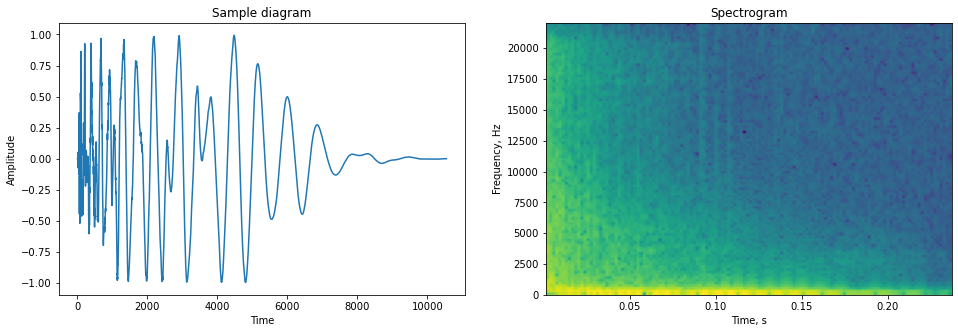

In [3]:
sound = AudioSegment.from_wav(sample_path)
sample = decode_wav(sample_path, mono=True)
x = graph_spectrogram(sample)

In [4]:
with open('gen_825.npy', 'rb') as f:
    gen_data = np.load(f)
f.close()
gen_data.shape

(64, 16000, 1)

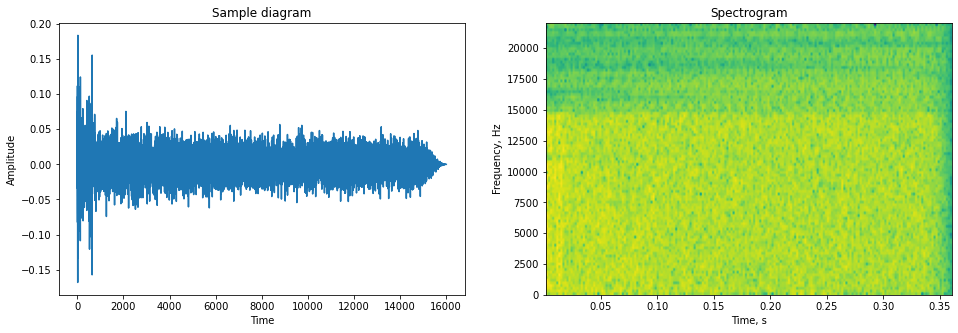

In [10]:
example = "./gen_825/example0.wav"
example = decode_wav(example, mono=True)
x = graph_spectrogram(example)

In [9]:
%cd "C:/Storage/Sample generator/gen_825"
for i in range(gen_data.shape[0]):
    audio = encode_wav(gen_data[i])
    audio = audio.set_frame_rate(44100)
    audio.export("example{}.wav".format(i), format="wav")
%cd "C:/Storage/Sample generator"

C:\Storage\Sample generator\gen_825
C:\Storage\Sample generator


## Preprocessing

In [4]:
def pad_sample(wave: np.array, sample_length: int):
        pad_size = sample_length - wave.shape[0]
        return np.pad(wave, [[0, pad_size], [0, 0]], constant_values=0)

In [5]:
def get_data(folder: str = "./train", form: str = 'wav', max_length: int = 16000):
    # pathlist = pathlib.Path(folder).glob('**/*.{}'.format(form))
    dataset = tf.data.Dataset.list_files("{}*.{}".format(folder, form), shuffle=False)
    
    data = []
    data_sh = []

    for path in dataset:
        path = path.numpy().decode("utf-8")
        wave = decode_wav(path, mono=True)
        if wave.shape[0] <= max_length:
            wave = pad_sample(wave, max_length)
            data.append(wave)
            data_sh.append(wave.shape)
    

    return np.array(data), np.array(data_sh)

In [6]:
data, data_sh = get_data(max_length=16000)
print(data.shape)

(255, 16000, 1)


In [7]:
with open('train_data.npy', 'wb') as f:
    np.save(f, data)

In [8]:
spec_gr = SpecgramsHelper(audio_length=16000,
                          spec_shape=(64, 1024),
                          overlap=0.75,
                          sample_rate=44100,
                          mel_downscale=1,
                          ifreq=True,
                          discard_dc=True)

In [9]:
melgrams = spec_gr.waves_to_melspecgrams(data)
melgrams.shape

TensorShape([255, 64, 1024, 2])

In [29]:
BATCH_SIZE = 16

train_dataset = tf.data.Dataset.from_tensor_slices(melgrams).batch(BATCH_SIZE)

## Model

In [11]:
from tensorflow.keras import layers

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Reshape([1, 1, 256], input_shape=[256]))
    model.add(layers.ZeroPadding2D(padding = (0, 15))) # Pad to fit the first conv2d layer
    model.add(layers.Conv2D(256, (1, 16), strides=(1, 1), padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.UpSampling2D(size=(2, 2)))
    assert model.output_shape == (None, 2, 32, 256)
    
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.UpSampling2D(size=(2, 2))) # output.shape: [None, 4, 64, 256]
    assert model.output_shape == (None, 4, 64, 256)
    
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.UpSampling2D(size=(2, 2))) # output.shape: [None, 8, 128, 256]
    assert model.output_shape == (None, 8, 128, 256)
    
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.UpSampling2D(size=(2, 2))) # output.shape: [None, 16, 256, 256]
    assert model.output_shape == (None, 16, 256, 256)
    
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.UpSampling2D(size=(2, 2))) # output.shape: [None, 32, 512, 128]
    assert model.output_shape == (None, 32, 512, 128)
    
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.UpSampling2D(size=(2, 2))) # output.shape: [None, 64, 1024, 64]
    assert model.output_shape == (None, 64, 1024, 64)
    
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2)) # output.shape: [None, 64, 1024, 32]
    assert model.output_shape == (None, 64, 1024, 32)
    
    model.add(layers.Conv2D(2, (1, 1), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 1024, 2)
    
    return model

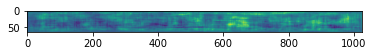

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 256])
generated_mel = generator(noise, training=False)

plt.imshow(generated_mel[0, :, :, 0])
plt.show()

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (1, 1), strides=(1, 1), padding='same', input_shape=[64, 1024, 2]))
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    assert model.output_shape == (None, 32, 512, 32)
    
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    assert model.output_shape == (None, 16, 256, 64)
    
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    assert model.output_shape == (None, 8, 128, 128)
    
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    assert model.output_shape == (None, 4, 64, 256)
    
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    assert model.output_shape == (None, 2, 32, 256)
    
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    assert model.output_shape == (None, 1, 16, 256)
    
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    assert model.output_shape == (None, 1, 16, 256)

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_mel)
print(decision)

tf.Tensor([[-6.721588e-08]], shape=(1, 1), dtype=float32)


## Optimization

In [16]:
import os
import time
from tqdm import tqdm

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
EPOCHS = 50
noise_dim = 256
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [24]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    # waves = spec_gr.melspecgrams_to_waves(predictions)
    
    fig = plt.figure(figsize=(16,2))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

In [27]:
def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
        start = time.time()

        for batch in tqdm(dataset):
            train_step(batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [30]:
train(train_dataset, EPOCHS)

  0%|                                                                                           | 0/50 [01:05<?, ?it/s]


KeyboardInterrupt: 

Восстановить чекпойнт:

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))